## Latent Space Models

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx

from edward.models import Normal, Poisson
#from observations import celegans

In [5]:
X = pd.read_csv("/Users/oliver/Downloads/network_subset.csv") # 2.14 GB
X.columns = ['id', 'dst_id',"src_id"]

In [6]:
X.iloc[:1000, 1:3].to_csv("Data/network_subset.edgelist",sep = " " ,index = False)

In [7]:
G = nx.read_edgelist("Data/network_subset.edgelist") # read and parse edgelist to (networkx) graph

In [8]:
A = nx.adjacency_matrix(G) # make Adjacency matrix

In [9]:
x_train = np.asarray(A.todense()) # convert Adjacency matrix to numpy array

## Visualization of network data (subset)

In [118]:
nx.draw(G, node_size = 5)  # networkx draw()
plt.draw()

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:137: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


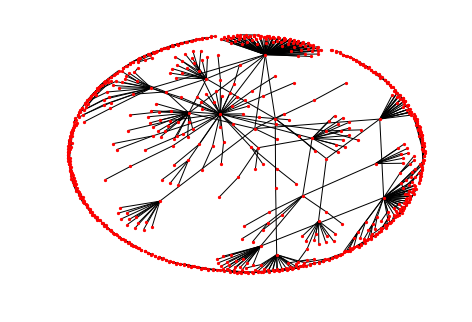

In [119]:
plt.show()

## Latent Space Models

In [35]:
from edward.models import Normal, Poisson

N = x_train.shape[0]  # number of data points
K = 100  # latent dimensionality

z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))

# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
xp = tf.tile(tf.reduce_sum(tf.pow(z, 2), 1, keepdims=True), [1, N])
# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
xp = xp + tf.transpose(xp) - 2 * tf.matmul(z, z, transpose_b=True)
# 3. Invert the pairwise distances and make rate along diagonals to
# be close to zero.
xp = 1.0 / tf.sqrt(xp + tf.diag(tf.zeros(N) + 1e3))

x = Poisson(rate=xp)

## Latent Space modified

In [18]:
from edward.models import Normal, Bernoulli

N = x_train.shape[0]  # number of data points
K = 100  # latent dimensionality

z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))
b = Normal(loc=tf.zeros(1), scale = tf.ones(1))

# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile
# it to create N identical rows.
pi = tf.tile(tf.reduce_sum(tf.pow(z, 2), 1, keepdims=True), [1, N])
# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2
# - 2 z_i^T z_j.
pi = pi + tf.transpose(pi) - 2 * tf.matmul(z, z, transpose_b=True)
# 3. minus pairwise distances and make rate along diagonals to
# be close to zero.
pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))

pi = tf.sigmoid(pi+b) #med bias (mange eller få links)

x = Bernoulli(pi)

In [19]:
inference = ed.MAP([z,b], data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [20]:
inference.run(n_iter=250, logdir = "log")

250/250 [100%] ██████████████████████████████ Elapsed: 31s | Loss: 581613.000

In [141]:
#inference.initialize(logdir='log')

#tf.global_variables_initializer().run()

#for _ in range(inference.n_iter):
#  info_dict = inference.update()
#  inference.print_progress(info_dict)

#inference.finalize()

In [142]:
#Z_pred = x.mean().eval().argmax(axis=1)
#print("Result (label flip can happen):")
#print("Predicted")
#print(Z_pred)

TypeError: unhashable type: 'numpy.ndarray'

In [13]:
x.eval()

array([[0, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 0, 1]], dtype=int32)

In [19]:
x_train

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Visualization of Latent Space Model result

In [139]:
G=nx.from_numpy_matrix(x.eval())

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:137: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


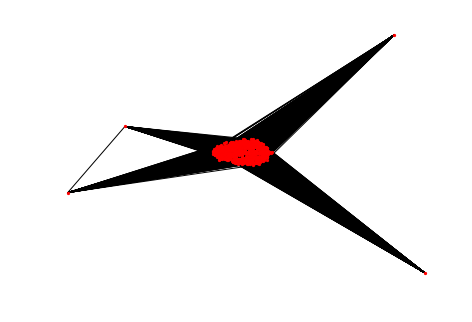

In [140]:
nx.draw(G, node_size = 5)  # networkx draw()
plt.draw()
plt.show()

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:137: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


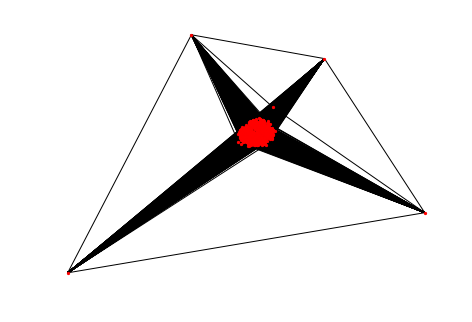

In [123]:
G=nx.from_numpy_matrix(x.eval())
nx.draw(G, node_size = 5)  # networkx draw()
plt.draw()
plt.show()